In [ ]:
!pip install torch torchvision
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import random
import cv2
import keras
import tensorflow as tf

from matplotlib.image import imread
from os import listdir
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras.utils import to_categorical
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
print(torch.__version__)
print(tf.__version__)

2.1.0+cu118
2.14.0


# **Dataset Implementation**

In [ ]:
from google.colab import drive

# path to dataset in Google Drive
dataset_path = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation'

classes = os.listdir(dataset_path)


num_classes = len(classes)


num_samples_per_class = {}
for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    num_samples = len(os.listdir(class_dir))
    num_samples_per_class[class_name] = num_samples

# number of samples in the dataset
total_samples = sum(num_samples_per_class.values())

print(f"Number of classes: {num_classes}")
print(f"Total number of samples: {total_samples}")

Number of classes: 39
Total number of samples: 55562


In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np

def load_random_image_from_each_class(dataset_path, target_size=(256, 256)):
    random_images = []

    for class_name in classes:
        class_dir = os.path.join(dataset_path, class_name)
        class_images = os.listdir(class_dir)

        random_image_name = random.choice(class_images)
        random_image_path = os.path.join(class_dir, random_image_name)

        random_image = load_and_preprocess_image(random_image_path, target_size)
        random_images.append(random_image)

    return random_images

random_images = load_random_image_from_each_class(dataset_path)

fig, axes = plt.subplots(6, 7, figsize=(14, 12))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(random_images):
        ax.imshow(random_images[i])
        ax.axis('off')
    else:
        ax.axis('off')

combined_image_path = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/combined_random_images.png'
plt.savefig(combined_image_path, bbox_inches='tight', pad_inches=0.1)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("Class names:")
for class_name in classes:
    print(class_name)

Class names:
Apple___Cedar_apple_rust
Background_without_leaves
Apple___Black_rot
Corn___Common_rust
Apple___healthy
Cherry___healthy
Corn___Cercospora_leaf_spot Gray_leaf_spot
Blueberry___healthy
Apple___Apple_scab
Cherry___Powdery_mildew
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Grape___Esca_(Black_Measles)
Peach___healthy
Grape___Black_rot
Corn___healthy
Grape___healthy
Orange___Haunglongbing_(Citrus_greening)
Corn___Northern_Leaf_Blight
Pepper,_bell___Bacterial_spot
Peach___Bacterial_spot
Strawberry___healthy
Pepper,_bell___healthy
Raspberry___healthy
Tomato___Bacterial_spot
Squash___Powdery_mildew
Strawberry___Leaf_scorch
Soybean___healthy
Potato___healthy
Potato___Late_blight
Potato___Early_blight
Tomato___healthy
Tomato___Late_blight
Tomato___Tomato_mosaic_virus
Tomato___Leaf_Mold
Tomato___Septoria_leaf_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Target_Spot
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Early_blight


# **Types of classes**

In [ ]:
disease_classes = [class_name for class_name in classes if not class_name.endswith("healthy") and not class_name.endswith("Background_without_leaves")]
healthy_classes = [class_name for class_name in classes if class_name.endswith("healthy")]
non_leaf_image_classes = [class_name for class_name in classes if class_name.endswith("Background_without_leaves")]

num_disease_classes = len(disease_classes)
num_healthy_classes = len(healthy_classes)
num_non_leaf_image_classes = len(non_leaf_image_classes)

print(f"Number of disease classes: {num_disease_classes}")
print("Disease class names:")
for class_name in disease_classes:
    print(class_name)

print(f"Number of healthy classes: {num_healthy_classes}")
print("Healthy class names:")
for class_name in healthy_classes:
    print(class_name)

print(f"Number of non leaf image classes: {num_non_leaf_image_classes}")
print("Non-leaf image class names:")
for class_name in non_leaf_image_classes:
    print(class_name)

Number of disease classes: 26
Disease class names:
Apple___Cedar_apple_rust
Apple___Black_rot
Corn___Common_rust
Corn___Cercospora_leaf_spot Gray_leaf_spot
Apple___Apple_scab
Cherry___Powdery_mildew
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Grape___Esca_(Black_Measles)
Grape___Black_rot
Orange___Haunglongbing_(Citrus_greening)
Corn___Northern_Leaf_Blight
Pepper,_bell___Bacterial_spot
Peach___Bacterial_spot
Tomato___Bacterial_spot
Squash___Powdery_mildew
Strawberry___Leaf_scorch
Potato___Late_blight
Potato___Early_blight
Tomato___Late_blight
Tomato___Tomato_mosaic_virus
Tomato___Leaf_Mold
Tomato___Septoria_leaf_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Target_Spot
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Early_blight
Number of healthy classes: 12
Healthy class names:
Apple___healthy
Cherry___healthy
Blueberry___healthy
Peach___healthy
Corn___healthy
Grape___healthy
Strawberry___healthy
Pepper,_bell___healthy
Raspberry___healthy
Soybean___healthy
Potato___health

# **Dataframe and Visual Graphplot of the classes**

In [ ]:
class_counts = {}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

img_per_class = pd.DataFrame(class_counts.values(), index=class_counts.keys(), columns=["no. of images"])
img_per_class = img_per_class.sort_values(by='no. of images', ascending=False)
img_per_class

no. of images
Orange___Haunglongbing_(Citrus_greening)                5508
Tomato___Tomato_Yellow_Leaf_Curl_Virus                  5357
Soybean___healthy                                       5098
Peach___Bacterial_spot                                  2297
Tomato___Bacterial_spot                                 2127
Tomato___Late_blight                                    1909
Squash___Powdery_mildew                                 1835
Tomato___Septoria_leaf_spot                             1778
Tomato___Spider_mites Two-spotted_spider_mite           1690
Apple___healthy                                         1645
Tomato___healthy                                        1606
Blueberry___healthy                                     1502
Pepper,_bell___healthy                                  1478
Tomato___Target_Spot                                    1404
Grape___Esca_(Black_Measles)                            1390
Corn___Common_rust                                      1201
Grape___Black_rot                                       1180
Corn___healthy                                          1162
Background_without_leaves                               1143
Strawberry___Leaf_scorch                                1116
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)              1083
Cherry___Powdery_mildew                                 1052
Potato___Early_blight                                   1014
Potato___Late_blight                                    1000
Tomato___Early_blight                                   1000
Pepper,_bell___Bacterial_spot                            997
Corn___Northern_Leaf_Blight                              985
Tomato___Leaf_Mold                                       952
Cherry___healthy                                         862
Apple___Apple_scab                                       630
Apple___Black_rot                                        621
Corn___Cercospora_leaf_spot Gray_leaf_spot               513
Strawberry___healthy                                     456
Grape___healthy                                          433
Tomato___Tomato_mosaic_virus                             380
Raspberry___healthy                                      371
Peach___healthy                                          360
Apple___Cedar_apple_rust                                 275
Potato___healthy                                         152

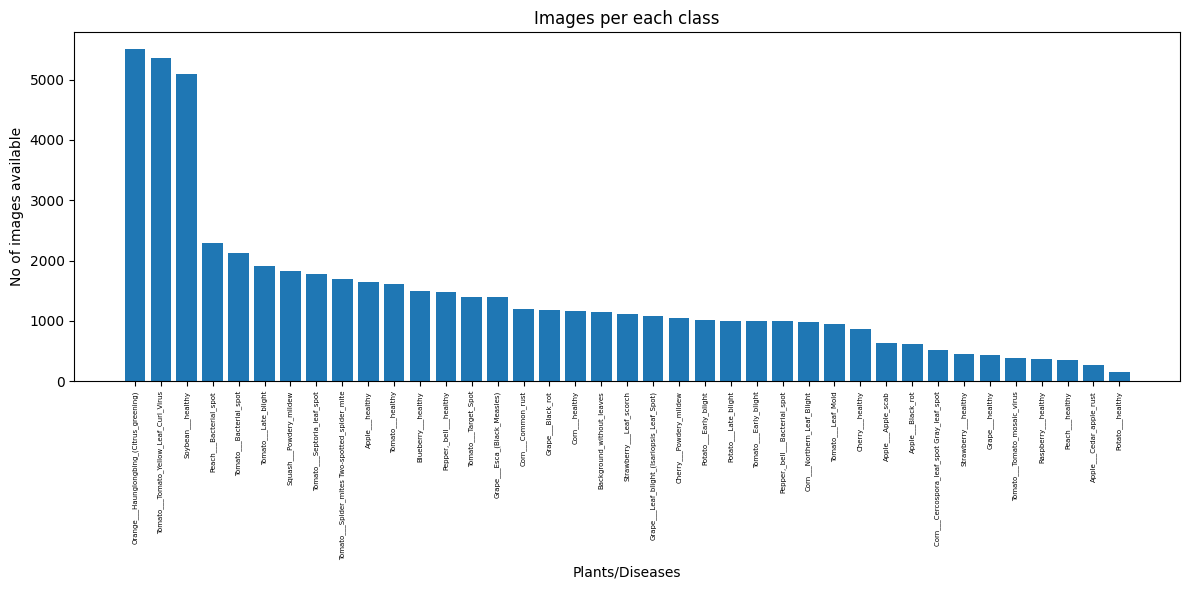

In [ ]:
img_per_class = img_per_class.sort_values(by='no. of images', ascending=False)

# Bar plot to visualize the number of images per class
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.bar(img_per_class.index, img_per_class['no. of images'])
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(img_per_class.index, fontsize=5, rotation=90)
plt.title('Images per each class')
plt.tight_layout()
plt.show()

# **Preprocessing Dataset**

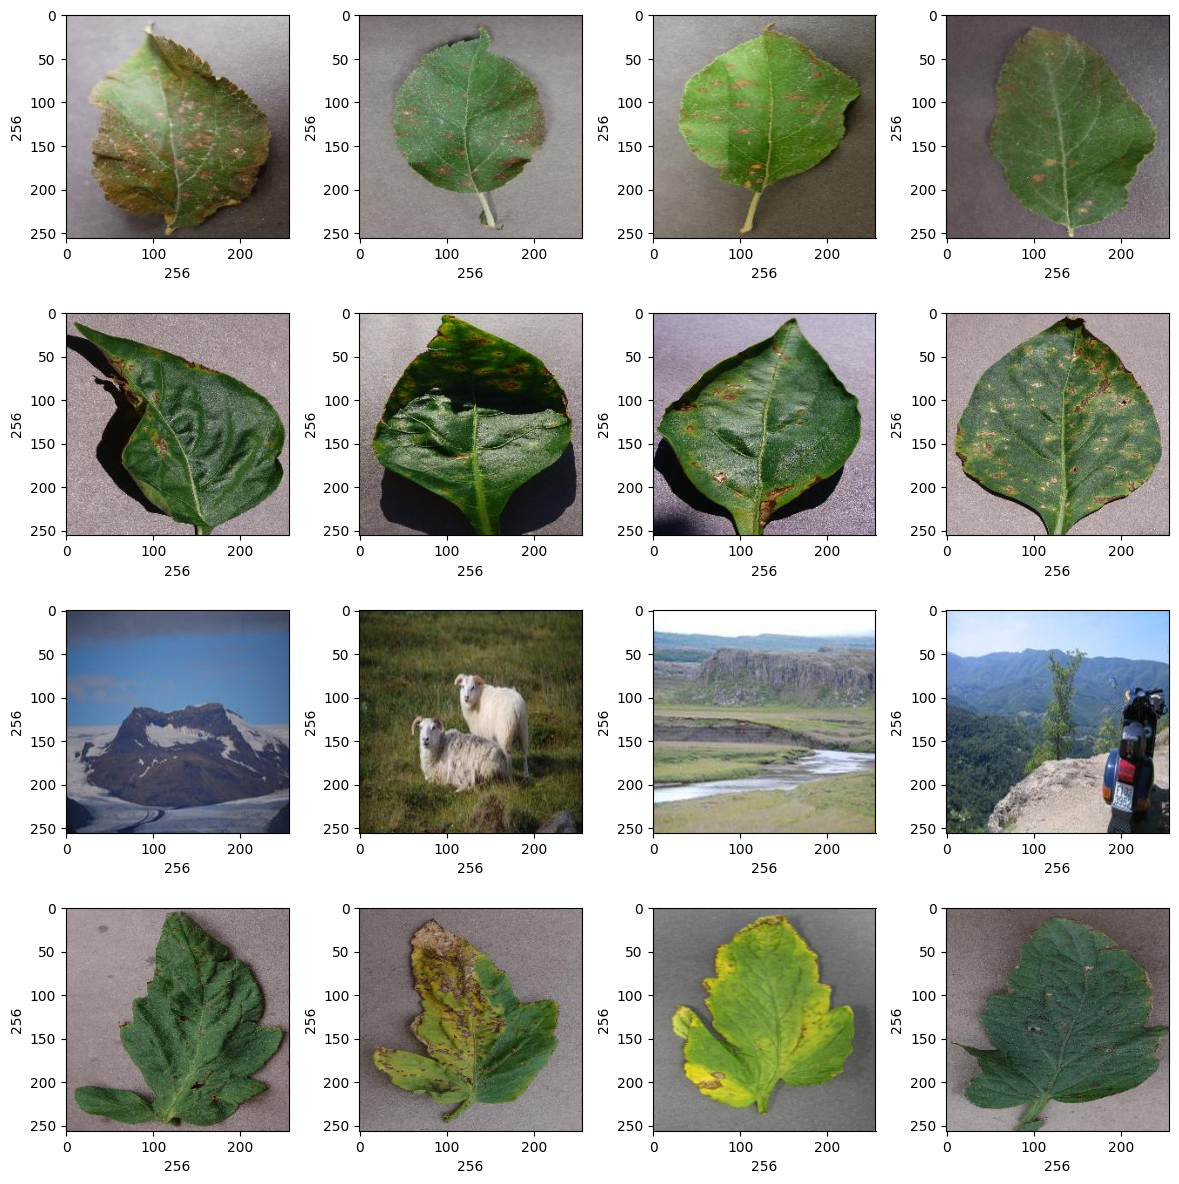

In [ ]:
img_paths = [
    '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/Apple___Cedar_apple_rust',
    '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/Pepper,_bell___Bacterial_spot',
    '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/Background_without_leaves',
    '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/Tomato___Bacterial_spot'
]

plt.figure(figsize=(12, 12))
for i, img_path in enumerate(img_paths):
    for j in range(1, 5):
        plt.subplot(4, 4, i * 4 + j)
        plt.tight_layout()
        random_image = imread(os.path.join(img_path, random.choice(sorted(os.listdir(img_path)))))
        plt.imshow(random_image)
        plt.xlabel(random_image.shape[1], fontsize=10)
        plt.ylabel(random_image.shape[0], fontsize=10)

plt.show()


In [ ]:
resize_img_path = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/Background_without_leaves'

target_size = (256, 256)

for filename in os.listdir(resize_img_path):
    if filename.endswith('.jpg'):
        image = Image.open(os.path.join(resize_img_path, filename))
        image = image.resize(target_size, Image.ANTIALIAS)
        image.save(os.path.join(resize_img_path, filename))
        image.close()

print("Images resized and saved.")
plt.figure(figsize=(12, 12))
for i in range(1,5):
  plt.subplot(1, 4, i)
  plt.tight_layout()
  random_image = imread(os.path.join(resize_img_path, random.choice(sorted(os.listdir(resize_img_path)))))
  plt.imshow(random_image)
  plt.xlabel(random_image.shape[1], fontsize=10)
  plt.ylabel(random_image.shape[0], fontsize=10)
plt.show()
image = Image.open('/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/Background_without_leaves/image (1001).jpg')
width, height = image.size
print({width}, {height})

<ipython-input-11-2ad0ed7bf1a4>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(target_size, Image.ANTIALIAS)


Images resized and saved.


{256} {256}


# **Train-Test split**

In [ ]:
import os
import shutil
import random

# Define paths
output_dir = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation'
train_dir = os.path.join(output_dir, 'train')
valid_dir = os.path.join(output_dir, 'valid')
test_dir = os.path.join(output_dir, 'test')

# Check if the output directories already exist, and if so, delete them
for dir_to_delete in [train_dir, valid_dir, test_dir]:
    if os.path.exists(dir_to_delete):
        shutil.rmtree(dir_to_delete)

# Define the ratios
train_ratio = 0.70
valid_ratio = 0.15
test_ratio = 0.15

# Loop through each class in the dataset
for class_name, num_images in img_per_class.iterrows():

    num_train = int(train_ratio * num_images)
    num_valid = int(valid_ratio * num_images)
    num_test = num_images - num_train - num_valid

    # Subdirectories for the class in each set
    class_train_dir = os.path.join(train_dir, class_name)
    class_valid_dir = os.path.join(valid_dir, class_name)
    class_test_dir = os.path.join(test_dir, class_name)

    os.makedirs(class_train_dir, exist_ok=True)
    os.makedirs(class_valid_dir, exist_ok=True)
    os.makedirs(class_test_dir, exist_ok=True)

    # List of image filenames for the class
    class_images = os.listdir(os.path.join(dataset_path, class_name))

    # Shuffle the list of images
    random.shuffle(class_images)

    # Copy images to each set
    for i, image_filename in enumerate(class_images):
        if i < num_train:
            shutil.copy2(os.path.join(dataset_path, class_name, image_filename), class_train_dir)
        elif i < num_train + num_valid:
            shutil.copy2(os.path.join(dataset_path, class_name, image_filename), class_valid_dir)
        else:
            shutil.copy2(os.path.join(dataset_path, class_name, image_filename), class_test_dir)

print("Dataset split complete.")


Dataset split complete.


In [ ]:
base_path = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/'
base_path2 = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/'
class_name = 'Tomato___Early_blight'

original_class_dir = os.path.join(base_path, class_name)
test_class_dir1 = os.path.join(base_path2, 'test', class_name)
train_class_dir1 = os.path.join(base_path2, 'train', class_name)
valid_class_dir1 = os.path.join(base_path2, 'valid', class_name)

print(len(os.listdir(original_class_dir)))
print(len(os.listdir(train_class_dir1)))
print(len(os.listdir(valid_class_dir1)))
print(len(os.listdir(test_class_dir1)))

1000
700
150
150


# **Data Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,              # Rescale pixel values to [0, 1]
    rotation_range=30,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,       # Randomly shift the width by up to 20%
    height_shift_range=0.2,      # Randomly shift the height by up to 20%
    shear_range=0.2,             # Shear intensity
    zoom_range=0.2,              # Randomly zoom into the image
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill in missing pixels using the nearest value
)
datagen_normal = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False,
    fill_mode='nearest'
)

In [ ]:
train_dir = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/train'
valid_dir = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/valid'

train_data_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_data_generator = datagen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 38876 images belonging to 39 classes.
Found 8317 images belonging to 39 classes.


In [ ]:
train_data_generator_normal = datagen_normal.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_data_generator_normal = datagen_normal.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 38876 images belonging to 39 classes.
Found 8317 images belonging to 39 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

train_data_generator_grayscaled = datagen_normal.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

valid_data_generator_grayscaled = datagen_normal.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

Found 38876 images belonging to 39 classes.
Found 8317 images belonging to 39 classes.


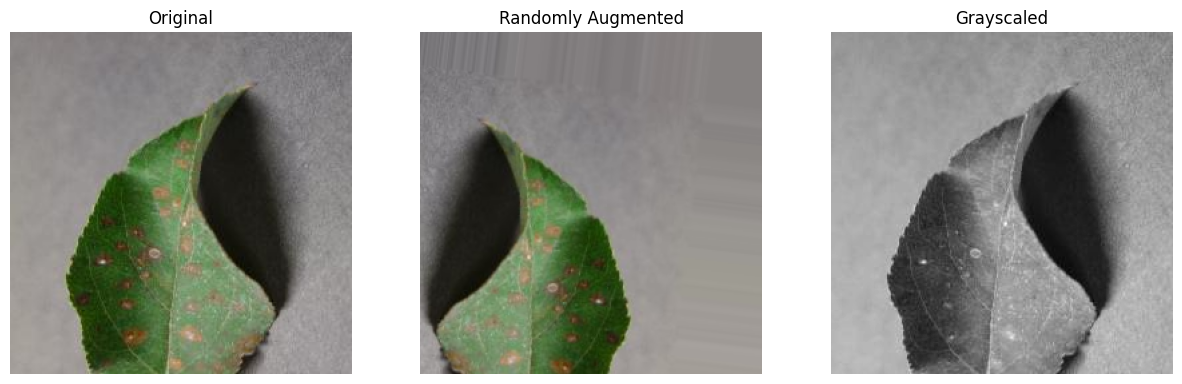

In [ ]:
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0  # Convert to float32 and normalize pixel values to [0, 1]
    return image

def show_augmented_images(original, augmented, grayscaled, save_path):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title('Original')
    plt.axis('off')

    # Randomly Augmented Image
    plt.subplot(1, 3, 2)
    plt.imshow(augmented)
    plt.title('Randomly Augmented')
    plt.axis('off')

    # Grayscaled Image
    plt.subplot(1, 3, 3)
    grayscaled_image = cv2.cvtColor((original * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    plt.imshow(grayscaled_image, cmap='gray')  # Display grayscale image
    plt.title('Grayscaled')
    plt.axis('off')

    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()

# Paths of three random images
image_paths = [
    '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/train/Apple___Cedar_apple_rust/image (112).JPG',
    '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/train/Pepper,_bell___healthy/image (1012).JPG',
    '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/train/Tomato___Spider_mites Two-spotted_spider_mite/image (1021).JPG',
]

# Load and preprocess each image
for i, image_path in enumerate(image_paths):

    original_image = load_and_preprocess_image(image_path)
    augmented_image = datagen.random_transform(original_image)
    grayscaled_image = cv2.cvtColor((original_image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    save_directory = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/'
    save_path = f'{save_directory}augmented_image_{i+1}.png'

    show_augmented_images(original_image, augmented_image, grayscaled_image, save_path)

# **Teacher Model**

*Creating a GoogLeNet (Inception) Model*

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers, models
import keras

In [ ]:
base_teacher_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_teacher_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_1418 (Conv2D)        (None, 127, 127, 32)         864       ['input_16[0][0]']            
                                                                                                  
 batch_normalization_1410 (  (None, 127, 127, 32)         96        ['conv2d_1418[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activation_1410 (Activatio  (None, 127, 127, 32)         0         ['batch_normalizati

In [ ]:
for layer in base_teacher_model.layers:
  layer.trainable = False

In [ ]:
x = GlobalAveragePooling2D()(base_teacher_model.output)
predictions = Dense(39, activation='softmax')(x)
teacher_model = Model(inputs=base_teacher_model.input, outputs=predictions)
teacher_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization[0][0

In [ ]:
teacher_model.compile(optimizer = "adam", loss= keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=3, verbose=1)
mc = ModelCheckpoint(filepath="best_model.h5", monitor="val_accuracy", min_delta=0.01, patience=3, verbose=1, save_best_only=True)
callback = [es, mc]

In [ ]:
import torch
import torchvision
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import multiprocessing

def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
print(device)
num_cores = multiprocessing.cpu_count()
print(num_cores)

cpu
2


# **Training the Teacher Model**

In [ ]:
train_teacher_model = teacher_model.fit_generator(train_data_generator,
                                        steps_per_epoch=50,
                                        epochs=10,
                                        verbose=1,
                                        callbacks= callback,
                                        validation_data= valid_data_generator,
                                        validation_steps=50)

<ipython-input-21-c420bed41417>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  train_teacher_model = teacher_model.fit_generator(train_data_generator,


Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 2.7151 - accuracy: 0.3288 
Epoch 1: val_accuracy improved from -inf to 0.52625, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 1383s 28s/step - loss: 2.7151 - accuracy: 0.3288 - val_loss: 1.9527 - val_accuracy: 0.5263
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 1.6551 - accuracy: 0.5806 
Epoch 2: val_accuracy improved from 0.52625 to 0.64688, saving model to best_model.h5
50/50 [==============================] - 1202s 24s/step - loss: 1.6551 - accuracy: 0.5806 - val_loss: 1.3901 - val_accuracy: 0.6469
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 1.2315 - accuracy: 0.6875 
Epoch 3: val_accuracy improved from 0.64688 to 0.72000, saving model to best_model.h5
50/50 [==============================] - 1141s 23s/step - loss: 1.2315 - accuracy: 0.6875 - val_loss: 1.1067 - val_accuracy: 0.7200
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 1.0184 - accuracy: 0.7356 
Epoch 4: val_accuracy improved from 0.72000 to 0.74750, saving model to best_model.h5
50/50 [==============================] - 1060s 21s/step - los

Train Accuracy (best epoch): 0.80
Validation Accuracy (best epoch): 0.79


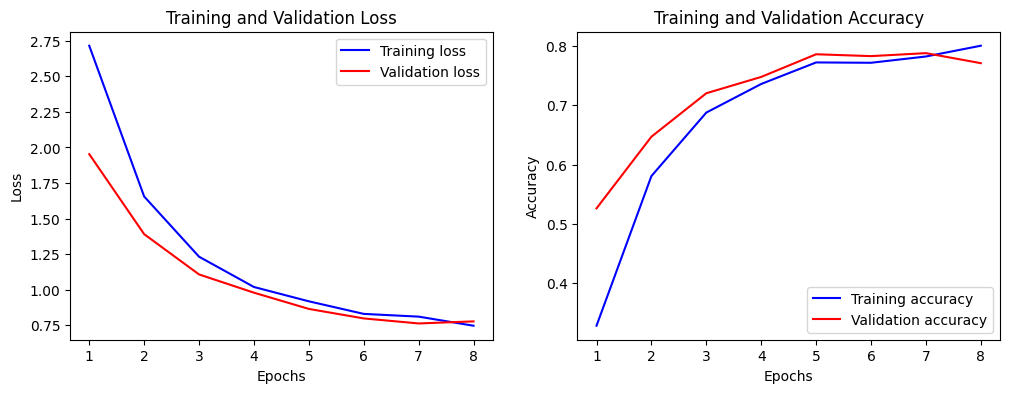

In [ ]:
# Visual plot showing accuracy scores of teacher model
history = train_teacher_model.history
train_loss = history['loss']
train_accuracy = history['accuracy']
val_loss = history['val_loss']
val_accuracy = history['val_accuracy']

train_accuracy_last_epoch = train_accuracy[-1]
val_accuracy_last_epoch = val_accuracy[-2]

print(f"Train Accuracy (best epoch): {train_accuracy_last_epoch:.2f}")
print(f"Validation Accuracy (best epoch): {val_accuracy_last_epoch:.2f}")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 [==============================] - 2s 2s/step


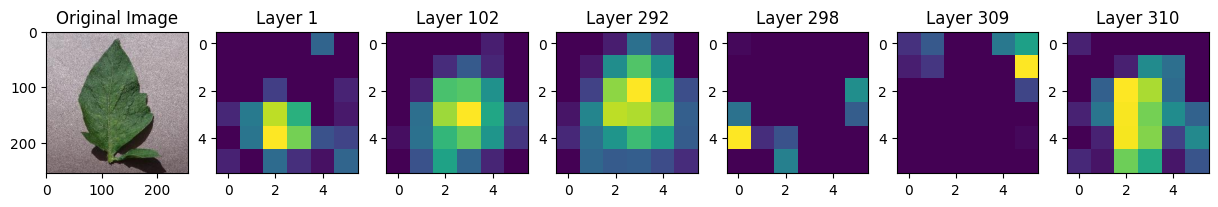

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

img_path = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/train/Tomato___Spider_mites Two-spotted_spider_mite/image (1017).JPG'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(256, 256, 3))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

base_teacher_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
data_path = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation'
combined_image_path = os.path.join(data_path, 'visualization_through_parent_model.png')

layer_names = [layer.name for layer in base_teacher_model.layers]
random_layer_indices = np.random.choice(len(layer_names) - 2, size=3, replace=False)
random_layer_indices.sort()
selected_layer_indices = [1]
selected_layer_indices.extend(random_layer_indices)
selected_layer_indices.extend([len(layer_names) - 2, len(layer_names) - 1])

def visualize_activations(model, img_array, selected_layer_indices):
    activations = model.predict(img_array)

    plt.figure(figsize=(15, 4))

    plt.subplot(1, len(selected_layer_indices) + 1, 1)
    plt.imshow(img)
    plt.title('Original Image')

    for i, layer_index in enumerate(selected_layer_indices):
        plt.subplot(1, len(selected_layer_indices) + 1, i + 2)
        activation_map = activations[0, :, :, layer_index]
        activation_map_normalized = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
        plt.imshow(activation_map_normalized, cmap='viridis', vmin=0, vmax=1)  # Display the normalized activation map
        plt.title(f'Layer {layer_index}')

    plt.show()

visualize_activations(base_teacher_model, img_array, selected_layer_indices)

# **Generating Soft Targets from Teacher Model**

In [ ]:
teacher_model = keras.models.load_model("/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/best_model.h5")

In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())

In [ ]:
import tensorflow as tf
from tqdm import tqdm

try:
      gpus = tf.config.experimental.list_physical_devices('GPU')
      if gpus:
        try:
          for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)

      def predict_generator_in_batches(generator, model, steps):
          all_logits = []
          for _ in tqdm(range(steps), desc="Processing Batches"):
              batch_data, _ = next(generator)
              logits_batch = model.predict_on_batch(batch_data)
              all_logits.append(logits_batch)
          return np.vstack(all_logits)

      batch_size = 32
      temperature = 5

      train_logits = predict_generator_in_batches(train_data_generator, teacher_model, len(train_data_generator))
      valid_logits = predict_generator_in_batches(valid_data_generator, teacher_model, len(valid_data_generator))

      train_soft_targets = tf.nn.softmax(train_logits / temperature)
      valid_soft_targets = tf.nn.softmax(valid_logits / temperature)
except Exception as e:
      print(f"Error: {e}")
      import traceback
      traceback.print_exc()


Physical devices cannot be modified after being initialized


Processing Batches: 100%|██████████| 260/260 [37:57<00:00,  8.76s/it]


In [ ]:
np.save('/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/Train_soft_values/train_soft_targets.npy', train_soft_targets)
np.save('/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/Valid_soft_values/valid_soft_targets.npy', valid_soft_targets)

In [ ]:
train_soft_targets = np.load('/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/Train_soft_values/train_soft_targets.npy')
valid_soft_targets = np.load('/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/Valid_soft_values/valid_soft_targets.npy')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

train_predicted_classes = np.argmax(train_soft_targets, axis=1)
valid_predicted_classes = np.argmax(valid_soft_targets, axis=1)

train_true_classes = train_data_generator.classes
valid_true_classes = valid_data_generator.classes

train_conf_matrix = confusion_matrix(train_true_classes, train_predicted_classes)
valid_conf_matrix = confusion_matrix(valid_true_classes, valid_predicted_classes)

num_classes = len(train_conf_matrix)

tp_list_train, fp_list_train, tn_list_train, fn_list_train = [], [], [], []
tp_list_valid, fp_list_valid, tn_list_valid, fn_list_valid = [], [], [], []

for i in range(num_classes):
    tp_train = train_conf_matrix[i, i]
    fp_train = np.sum(train_conf_matrix[:, i]) - tp_train
    fn_train = np.sum(train_conf_matrix[i, :]) - tp_train
    tn_train = np.sum(train_conf_matrix) - (tp_train + fp_train + fn_train)

    tp_valid = valid_conf_matrix[i, i]
    fp_valid = np.sum(valid_conf_matrix[:, i]) - tp_valid
    fn_valid = np.sum(valid_conf_matrix[i, :]) - tp_valid
    tn_valid = np.sum(valid_conf_matrix) - (tp_valid + fp_valid + fn_valid)

    tp_list_train.append(tp_train)
    fp_list_train.append(fp_train)
    tn_list_train.append(tn_train)
    fn_list_train.append(fn_train)

    tp_list_valid.append(tp_valid)
    fp_list_valid.append(fp_valid)
    tn_list_valid.append(tn_valid)
    fn_list_valid.append(fn_valid)

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming you already have the true and predicted classes
train_true_classes = train_data_generator.classes
valid_true_classes = valid_data_generator.classes

train_predicted_classes = np.argmax(train_soft_targets, axis=1)
valid_predicted_classes = np.argmax(valid_soft_targets, axis=1)

# Calculate precision, recall, and F1 score
train_precision = precision_score(train_true_classes, train_predicted_classes, average='macro')
train_recall = recall_score(train_true_classes, train_predicted_classes, average='macro')
train_f1 = f1_score(train_true_classes, train_predicted_classes, average='macro')
train_accuracy = accuracy_score(train_true_classes, train_predicted_classes)

valid_precision = precision_score(valid_true_classes, valid_predicted_classes, average='macro')
valid_recall = recall_score(valid_true_classes, valid_predicted_classes, average='macro')
valid_f1 = f1_score(valid_true_classes, valid_predicted_classes, average='macro')
valid_accuracy = accuracy_score(valid_true_classes, valid_predicted_classes)

# Print the results
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1)
print("Training Accuracy:", train_accuracy)

print("Validation Precision:", valid_precision)
print("Validation Recall:", valid_recall)
print("Validation F1 Score:", valid_f1)
print("Validation Accuracy:", valid_accuracy)

Training Precision: 0.02585103597148298
Training Recall: 0.025746701863656744
Training F1 Score: 0.02534466377777152
Training Accuracy: 0.04859038995781459
Validation Precision: 0.025567440817914254
Validation Recall: 0.02603924600910699
Validation F1 Score: 0.02554240337926709
Validation Accuracy: 0.05037874233497655


# **Creating Student Model**

In [ ]:
from tensorflow.keras.applications import MobileNet
from keras.models import Sequential
from keras.layers import Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [ ]:
student_model = Sequential([
    Conv2D(16, (3, 3), input_shape=(256, 256, 3), padding='same'),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), padding='same'),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128),
    LeakyReLU(),
    Dense(39, activation='softmax', name='logits')
])

student_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                   

# **Knowledge Distillation**

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy

temperature = 6

def distillation_loss(y_true, y_pred):
    y_true_hard = y_true[:, :39]
    y_true_soft = y_true[:, 39:]

    y_pred_hard = y_pred[:, :39]
    y_pred_soft = y_pred[:, 39:]

    hard_loss = categorical_crossentropy(y_true_hard, y_pred_hard)
    soft_loss = tf.keras.losses.KLD(y_true_soft, y_pred_soft)

    total_loss = hard_loss + (soft_loss / temperature**2)

    return total_loss

In [ ]:
train_data_generator_with_soft_targets = datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

train_data_generator_with_soft_targets.classes = np.concatenate([train_data_generator.classes, np.argmax(train_soft_targets, axis=1)])

valid_data_generator_with_soft_targets = datagen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_data_generator_with_soft_targets.classes = np.concatenate([valid_data_generator.classes, np.argmax(valid_soft_targets, axis=1)])

Found 38876 images belonging to 39 classes.
Found 8317 images belonging to 39 classes.


# **Training the Student Model**

In [ ]:
callback_student = [ModelCheckpoint(filepath="best_student_model.h5", monitor="val_accuracy", min_delta=0.01, patience=3, verbose=1, save_best_only=True)]

student_model.compile(optimizer='adam', loss=distillation_loss, metrics=['accuracy'])

**This one with temperature = 3**

In [ ]:
train_student_model = student_model.fit(
    train_data_generator_with_soft_targets,
    epochs=20,
    validation_data=valid_data_generator_with_soft_targets,
    callbacks=callback_student,
    steps_per_epoch=50,
    validation_steps=50
)

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 3.4915 - accuracy: 0.1488
Epoch 1: val_accuracy improved from -inf to 0.23937, saving model to best_student_model.h5
50/50 [==============================] - 888s 18s/step - loss: 3.4915 - accuracy: 0.1488 - val_loss: 3.0166 - val_accuracy: 0.2394


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 2.8014 - accuracy: 0.2637
Epoch 2: val_accuracy improved from 0.23937 to 0.34750, saving model to best_student_model.h5
50/50 [==============================] - 763s 15s/step - loss: 2.8014 - accuracy: 0.2637 - val_loss: 2.4330 - val_accuracy: 0.3475
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 2.2059 - accuracy: 0.4062
Epoch 3: val_accuracy improved from 0.34750 to 0.44563, saving model to best_student_model.h5
50/50 [==============================] - 743s 15s/step - loss: 2.2059 - accuracy: 0.4062 - val_loss: 2.0301 - val_accuracy: 0.4456
Epoch 4/20
50/50 [==============================] - ETA: 0s - loss: 1.9094 - accuracy: 0.4588
Epoch 4: val_accuracy improved from 0.44563 to 0.51688, saving model to best_student_model.h5
50/50 [==============================] - 640s 13s/step - loss: 1.9094 - accuracy: 0.4588 - val_loss: 1.7451 - val_accuracy: 0.5169
Epoch 5/20
50/50 [=========================

Train Accuracy (best epoch): 0.73
Validation Accuracy (best epoch): 0.76


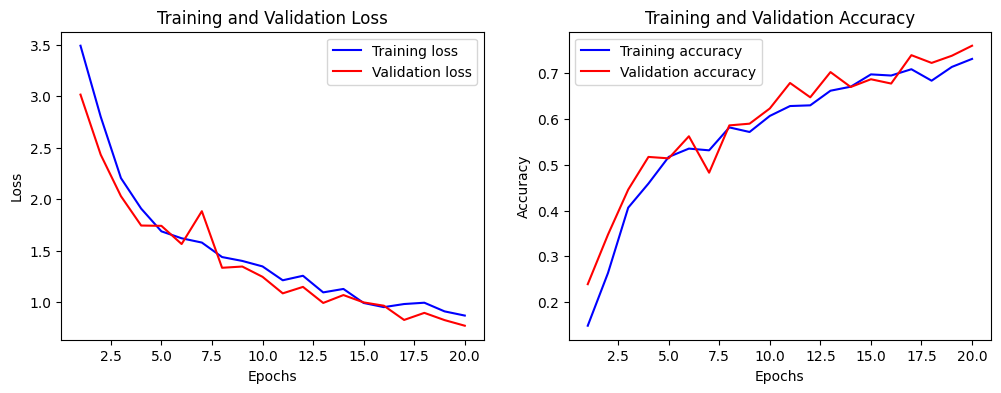

In [ ]:
# Visual plot showing accuracy scores of student model
history = train_student_model.history
train_loss = history['loss']
train_accuracy = history['accuracy']
val_loss = history['val_loss']
val_accuracy = history['val_accuracy']

train_accuracy_last_epoch = train_accuracy[-1]
val_accuracy_last_epoch = val_accuracy[-1]

print(f"Train Accuracy (best epoch): {train_accuracy_last_epoch:.2f}")
print(f"Validation Accuracy (best epoch): {val_accuracy_last_epoch:.2f}")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**This one with temperature = 6**

In [ ]:
train_student_model = student_model.fit(
    train_data_generator_with_soft_targets,
    epochs=20,
    validation_data=valid_data_generator_with_soft_targets,
    callbacks=callback_student,
    steps_per_epoch=50,
    validation_steps=50
)

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 3.2105 - accuracy: 0.1700
Epoch 1: val_accuracy improved from -inf to 0.25125, saving model to best_student_model.h5
50/50 [==============================] - 261s 5s/step - loss: 3.2105 - accuracy: 0.1700 - val_loss: 2.8627 - val_accuracy: 0.2512


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 2.4811 - accuracy: 0.3250
Epoch 2: val_accuracy improved from 0.25125 to 0.38625, saving model to best_student_model.h5
50/50 [==============================] - 263s 5s/step - loss: 2.4811 - accuracy: 0.3250 - val_loss: 2.2861 - val_accuracy: 0.3862
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 2.1232 - accuracy: 0.3956
Epoch 3: val_accuracy improved from 0.38625 to 0.45000, saving model to best_student_model.h5
50/50 [==============================] - 255s 5s/step - loss: 2.1232 - accuracy: 0.3956 - val_loss: 1.8695 - val_accuracy: 0.4500
Epoch 4/20
50/50 [==============================] - ETA: 0s - loss: 1.8247 - accuracy: 0.4893
Epoch 4: val_accuracy improved from 0.45000 to 0.51063, saving model to best_student_model.h5
50/50 [==============================] - 327s 7s/step - loss: 1.8247 - accuracy: 0.4893 - val_loss: 1.7188 - val_accuracy: 0.5106
Epoch 5/20
50/50 [============================

Train Accuracy (best epoch): 0.77
Validation Accuracy (best epoch): 0.78


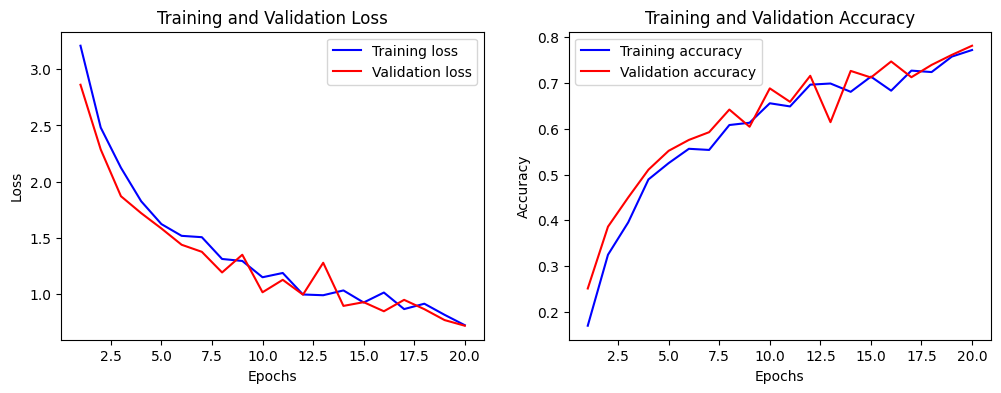

In [ ]:
# Visual plot showing accuracy scores of student model
history = train_student_model.history
train_loss = history['loss']
train_accuracy = history['accuracy']
val_loss = history['val_loss']
val_accuracy = history['val_accuracy']

train_accuracy_last_epoch = train_accuracy[-1]
val_accuracy_last_epoch = val_accuracy[-1]

print(f"Train Accuracy (best epoch): {train_accuracy_last_epoch:.2f}")
print(f"Validation Accuracy (best epoch): {val_accuracy_last_epoch:.2f}")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**This one with temperature = 9**

In [ ]:
train_student_model = student_model.fit(
    train_data_generator_with_soft_targets,
    epochs=20,
    validation_data=valid_data_generator_with_soft_targets,
    callbacks=callback_student,
    steps_per_epoch=50,
    validation_steps=50
)

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 3.2225 - accuracy: 0.1762
Epoch 1: val_accuracy improved from -inf to 0.23812, saving model to best_student_model.h5
50/50 [==============================] - 379s 8s/step - loss: 3.2225 - accuracy: 0.1762 - val_loss: 2.8806 - val_accuracy: 0.2381
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 2.7530 - accuracy: 0.2650
Epoch 2: val_accuracy improved from 0.23812 to 0.34438, saving model to best_student_model.h5
50/50 [==============================] - 363s 7s/step - loss: 2.7530 - accuracy: 0.2650 - val_loss: 2.3684 - val_accuracy: 0.3444
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 2.2947 - accuracy: 0.3625
Epoch 3: val_accuracy improved from 0.34438 to 0.43187, saving model to best_student_model.h5
50/50 [==============================] - 372s 7s/step - loss: 2.2947 - accuracy: 0.3625 - val_loss: 2.1055 - val_accuracy: 0.4319
Epoch 4/20
50/50 [==============================]

Train Accuracy (best epoch): 0.74
Validation Accuracy (best epoch): 0.74


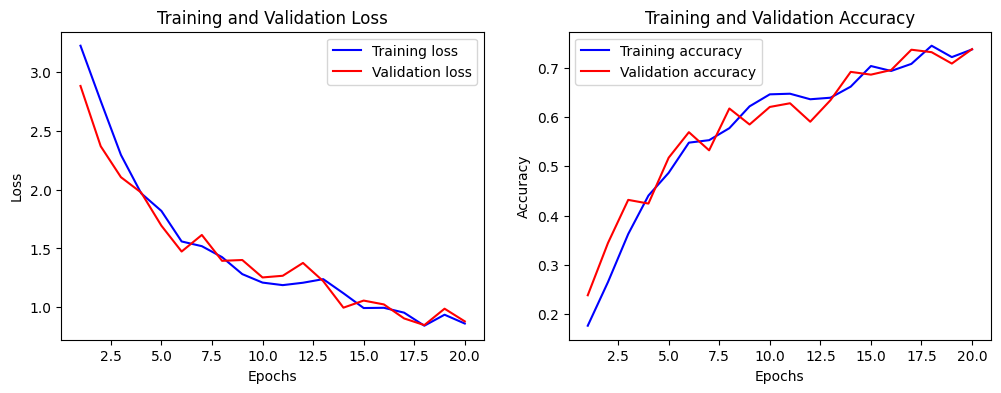

In [ ]:
# Visual plot showing accuracy scores of student model
history = train_student_model.history
train_loss = history['loss']
train_accuracy = history['accuracy']
val_loss = history['val_loss']
val_accuracy = history['val_accuracy']

train_accuracy_last_epoch = train_accuracy[-1]
val_accuracy_last_epoch = val_accuracy[-1]

print(f"Train Accuracy (best epoch): {train_accuracy_last_epoch:.2f}")
print(f"Validation Accuracy (best epoch): {val_accuracy_last_epoch:.2f}")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# **Control Experiment with Student Model for comparison**

In [ ]:
from tensorflow.keras.applications import MobileNet
from keras.models import Sequential
from keras.layers import Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [ ]:
control_student_model = Sequential([
    Conv2D(16, (3, 3), input_shape=(256, 256, 3), padding='same'),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), padding='same'),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128),
    LeakyReLU(),
    Dense(39, activation='softmax', name='logits')
])

control_student_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_99 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                 

In [ ]:
callback_control_student = [ModelCheckpoint(filepath="best_control_student_model.h5", monitor="val_accuracy", min_delta=0.01, patience=3, verbose=1, save_best_only=True)]

control_student_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
train_control_student_model = control_student_model.fit_generator(train_data_generator,
                                        steps_per_epoch=50,
                                        epochs=20,
                                        verbose=1,
                                        callbacks= callback_control_student,
                                        validation_data= valid_data_generator,
                                        validation_steps=50)

<ipython-input-53-9832cde8e90f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  train_control_student_model = control_student_model.fit_generator(train_data_generator,


Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 3.4662 - accuracy: 0.1388
Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to best_control_student_model.h5
50/50 [==============================] - 210s 4s/step - loss: 3.4662 - accuracy: 0.1388 - val_loss: 3.1386 - val_accuracy: 0.1875
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 2.8580 - accuracy: 0.2550
Epoch 2: val_accuracy improved from 0.18750 to 0.26625, saving model to best_control_student_model.h5
50/50 [==============================] - 227s 5s/step - loss: 2.8580 - accuracy: 0.2550 - val_loss: 2.6988 - val_accuracy: 0.2663
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 2.6067 - accuracy: 0.2926
Epoch 3: val_accuracy improved from 0.26625 to 0.37375, saving model to best_control_student_model.h5
50/50 [==============================] - 219s 4s/step - loss: 2.6067 - accuracy: 0.2926 - val_loss: 2.3207 - val_accuracy: 0.3738
Epoch 4/20
50/50 [=======

Train Accuracy (best epoch): 0.68
Validation Accuracy (best epoch): 0.69


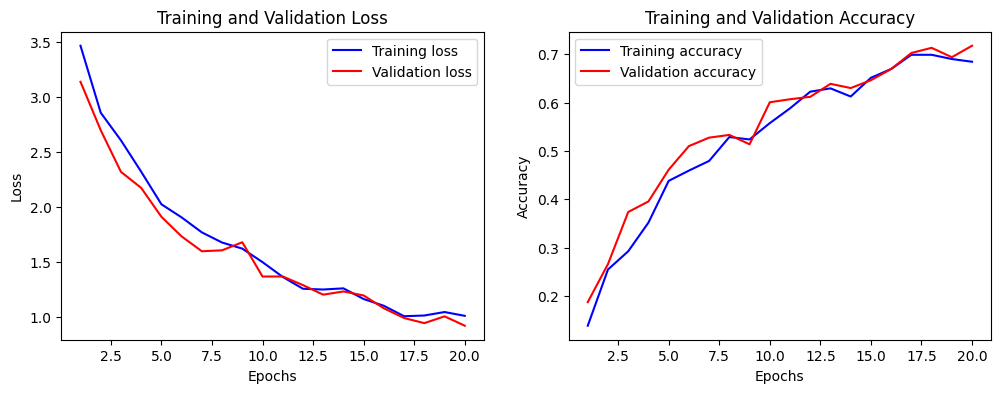

In [ ]:
# Visual plot showing accuracy scores of student model without distillation loss function
history = train_control_student_model.history
train_loss = history['loss']
train_accuracy = history['accuracy']
val_loss = history['val_loss']
val_accuracy = history['val_accuracy']

train_accuracy_last_epoch = train_accuracy[-1]
val_accuracy_last_epoch = val_accuracy[-2]

print(f"Train Accuracy (best epoch): {train_accuracy_last_epoch:.2f}")
print(f"Validation Accuracy (best epoch): {val_accuracy_last_epoch:.2f}")

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 [==============================] - 0s 136ms/step


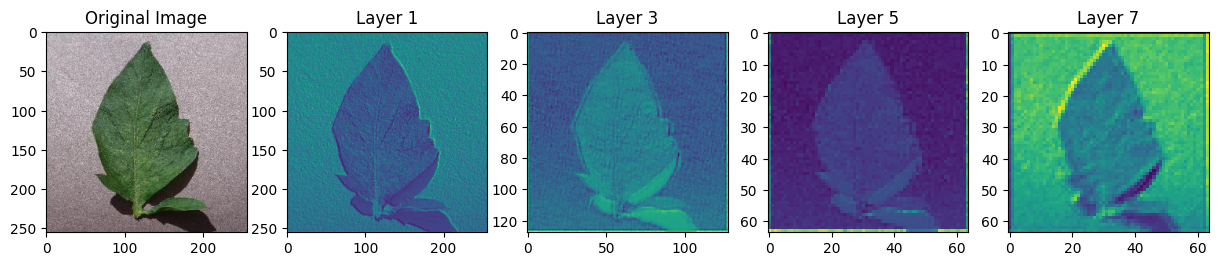

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing import image

img_path = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation/train/Tomato___Spider_mites Two-spotted_spider_mite/image (1017).JPG'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(256, 256, 3))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

layer_names = [layer.name for layer in control_student_model.layers if 'conv2d' in layer.name.lower()]
selected_layer_indices = [1, 3, 5, 7]
data_path = '/content/drive/MyDrive/Plant_leaf_diseases_dataset_without_augmentation'
combined_image_path = os.path.join(data_path, 'visualization_through_parent_model.png')

def visualize_activations(model, img_array, selected_layer_indices):
    activations = [model.layers[i].output for i in selected_layer_indices]
    activation_model = Model(inputs=model.input, outputs=activations)

    activations = activation_model.predict(img_array)

    plt.figure(figsize=(15, 4))

    plt.subplot(1, len(selected_layer_indices) + 1, 1)
    plt.imshow(img)
    plt.title('Original Image')

    for i, layer_index in enumerate(selected_layer_indices):
        plt.subplot(1, len(selected_layer_indices) + 1, i + 2)
        activation_map = activations[i][0, :, :, 0]
        activation_map_normalized = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
        plt.imshow(activation_map_normalized, cmap='viridis', vmin=0, vmax=1)  # Adjust vmin and vmax for better contrast
        plt.title(f'Layer {layer_index}')

    plt.savefig(combined_image_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()

visualize_activations(control_student_model, img_array, selected_layer_indices)